<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastcore.git
!python -m pip install git+https://github.com/fastai/fastai2

In [0]:
UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
!wget $UTILS -O utils.py

The aim of this notebook is to demonstrate a format for defining (hierarchical) directed graphs. Later we will show how to use this for Pytorch model creation and visualisation.

### Graphs

Let's define a compact way of representing directed graphs (suitable for describing neural networks) as python dictionaries. Each node has a *name* which should be a string, a *value* which can be anything and an (ordered) list of *inputs* representing incoming edges from other nodes. Inputs are ordered as they typically represent function args. We can alternatively provide a dict of *inputs* to represent named args. Here is our graph format:


```
Graph := {name: (value, [input])}
```

or

```
Graph := {name: (value, {input_name: input}}
```

Here is an example of such a Graph using both kinds of inputs:


In [0]:
#define some node values - just strings for now, 
#we'll use more interesting values later
A, B, C, D = 'Aa', 'Bb', 'Cc', 'Dd'

graph = {
    'a': (A, []),
    'b': (B, ['a']),
    'c': (C, {'x': 'a', 'y': 'c'}),
    'd': (D, ['b'])
}

It will be useful to be able to display Graphs. Here is a function that does that:

In [0]:
from utils import *

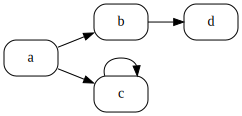

In [4]:
draw = lambda graph, max_depth=0: DotGraph({name: ({'tooltip': str(value)}, inputs) for name, (value, inputs) in graph.items()})
draw(graph)

The ```draw``` function above is just a thin wrapper around ```DotGraph``` which 
expects a standard Graph as input - with the constraint that *values* are dicts with fields that Graphviz understands (e.g. 'tooltip'.) If you hover over a node, you should see the *value* displayed as a tooltip. 

**Colors**

Let's make things a bit more interesting by adding some color based on a property of the nodes - in this case the value:

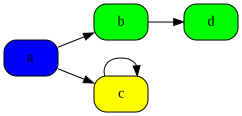

In [5]:
colors = {A: 'blue', B: 'green', C: 'yellow', D: 'green'}
draw = lambda graph, max_depth=0: DotGraph({name: ({'tooltip': str(value), 'fillcolor': colors[str(value)]}, inputs) for name, (value, inputs) in graph.items()})
draw(graph)

Choosing colors by hand is not the best use of our time so here's a helper to do it for us. ColorMap() is just a dictionary which populates itself with colors from a chosen palette when we ask for a missing key. Asking for the same key twice returns the same color which can be useful for coloring nodes consistently by some property (e.g. type.)

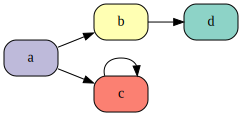

In [6]:
colors = ColorMap()
draw(graph)

We can inspect a ColorMap like this:

In [7]:
print(colors)

{'Aa': '#bebada', 'Bb': '#ffffb3', 'Cc': '#fb8072', 'Dd': '#8dd3c7'}


or like this:

In [8]:
colors

{'Aa': '#bebada', 'Bb': '#ffffb3', 'Cc': '#fb8072', 'Dd': '#8dd3c7'}

**Default inputs**

Commonly the graphs that we want to build resemble pipelines with many nodes taking the preceeding node as their only input. We can simplify the specification of such graphs by supplying the preceeding node as the default input if none are provided. (Note that *explicitly* providing an empty list/dict as inputs means that a node has no inputs.)


To use this feature we just replace calls to ```graph.items()``` with ```iter_nodes(graph)```. This provides the default inputs and does some other validation such as checking that node names are strings. Here is a new ```draw``` function using ```iter_nodes```:

In [0]:
draw = lambda graph, max_depth=0: DotGraph({name: ({'tooltip': str(value), 'fillcolor': colors[str(value)]}, inputs) for name, (value, inputs) in iter_nodes(graph)})

and a graph with a mixture of explicit and default inputs. 

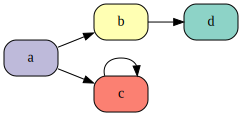

In [10]:
graph2 = {
    'a': (A, []),
    'b': B,
    'd': D, 
    'c': (C, ['a', 'c']),
}
draw(graph2)

We are free to refer to nodes which don't exist in the graph as inputs. These represent external nodes and don't have a value (so no 'tooltip' or 'fillcolor' in the diagram below.) 

Since node names are strings, we use the convention that names of external nodes are ints. This helps to make clear which inputs are external and has a further advantage that we shall see below.

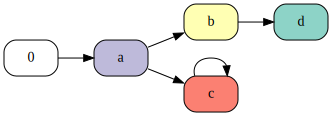

In [11]:
graph3 = {
    'a': (A, [0]),
    'b': B,
    'd': D, 
    'c': (C, ['a', 'c']),
}
draw(graph3)

Note that if we didn't provide explicit inputs for the first node the default is ```[0]``` anyway.

**Nested graphs**

Sometimes we want to display a graph with nested structure. We can do this by adding path separators '/' in node names:

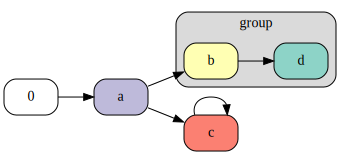

In [12]:
graph4 = {
    'a': A,
    'group/b': (B, ['a']),
    'c': (C, ['a', 'c']),
    'group/d': (D, ['group/b'])
}

draw(graph4)

We can have multiple levels of nesting and we can still use default inputs:

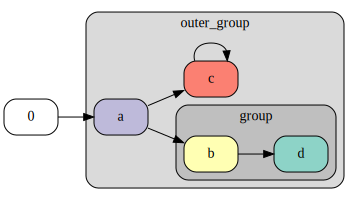

In [13]:
graph5 = {
    'outer_group/a': A,
    'outer_group/group/b': B,
    'outer_group/group/d': D,
    'outer_group/c': (C, ['outer_group/a', 'outer_group/c']),

}
draw(graph5)

It's annoying to have to add path prefixes to every node name and input. We want to be able to write this as a hierarchical graph, some of whose node *values* are themselves *graphs*. Let's express the graph above in hierarchical form. First we construct a graph for the nodes in ```group```:

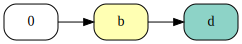

In [14]:
group = {'b': B, 'd': D}
draw(group)

Next we build a graph representing ```outer_group``` in which the subgraph ```group``` appears as a node value. 

By providing this node with a dictionary of inputs, keyed by its *external inputs* there is a natural way to bind these onto the inner graph. 

Here ```group``` has a single external input ```0``` and we want to bind it to the node ```a```:

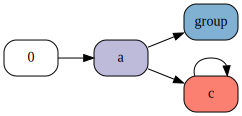

In [15]:
outer_group = {'a': A, 'group': (group, {0: 'a'}), 'c': (C, ['a', 'c'])}
draw(outer_group)

If our external inputs all are non-negative integers, we can use a list rather than a dict to represent binding of inputs, where the external inputs of the inner graph are now interpreted as indexes in the list instead of keys in a dict:

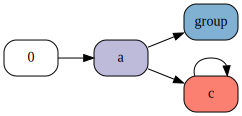

In [16]:
outer_group = {'a': A, 'group': (group, ['a']), 'c': (C, ['a', 'c'])}
draw(outer_group)

The diagram above expresses the hierarchical structure but it's sometimes nice to recover the expanded structure with path separated names. To do this we ```explode``` the graph into a single-level format:

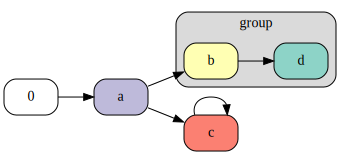

In [17]:
draw(explode(outer_group))

Now let's define the full graph which has a single node ```outer_group```:

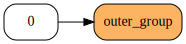

In [18]:
graph6 = {'outer_group': outer_group}
draw(graph6)

We can display the full nested structure by 'exploding' this:

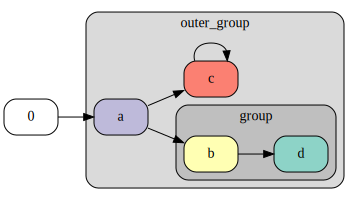

In [19]:
draw(explode(graph6))

We can also display intermediate levels of hierarchy by specifiying a ```max_levels``` argument to ```explode```:

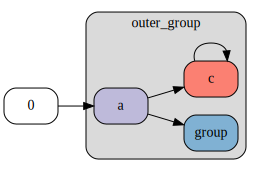

In [20]:
draw(explode(graph6, max_levels=1))

Here's a test that exploding in two stages is the same as doing it all at once:

In [0]:
#test
assert explode(explode(graph6, 1), 1) == explode(graph6)

Here's a more complicated graph with repeated groups and name clashes:

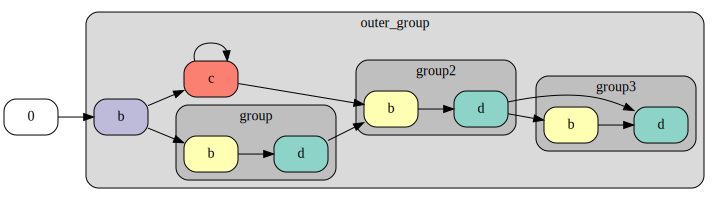

In [22]:
graph7 = {
    'outer_group': ({
        'b': (A, [0]), 
        'group':  {'b': (B, [0]), 'd': D},
        'group2': ({'b': (B, [0, 1]), 'd': D}, ['group', 'c']),
        'group3':  {'b': (B, [0]), 'd': (D, ['b', 0])},
        'c': (C, ['b', 'c']),
    }, [0])}

draw(explode(graph7))

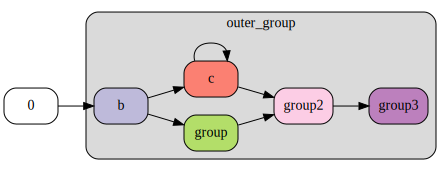

In [23]:
draw(explode(graph7, 1))

In [0]:
#test
assert explode(explode(graph7, 1), 1) == explode(graph7)

### Pytorch

Let's use the Graph datastructure that we've developed to explore some pytorch models. To start with let's try a ```fastai2.models.xresnet.XResNet``` model without alterations. Since this model is a subclass of ```nn.Sequential```, we already have quite a bit of information about the graph structure which we can use. 

Let's define a function to convert an ```nn.Sequential``` model into a graph and also a new ```draw``` function which colors nodes by type:

In [0]:
import torch
import torch.nn as nn
import fastai2

@to_graph.register(nn.Sequential)
def f(x):
    return {f'node_{k}': v for k,v in x._modules.items()}

colors = ColorMap()
def draw(network, **kwargs):
    return DotGraph({p: ({'fillcolor': colors[type(v).__name__], 'tooltip': str(v)}, inputs) for p, (v, inputs) in iter_nodes(to_graph(network))}, **kwargs)

Now we can try drawing the model:

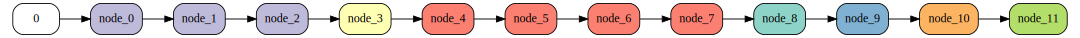

In [26]:
model = fastai2.vision.models.xresnet.XResNet(fastai2.layers.SeparableBlock, 1, [2,2,2,2], c_in=3, c_out=10, sa=True)
draw(model)

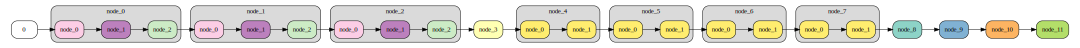

In [27]:
draw(explode(model))

Not a bad start! The node names could do with a bit of work. Here is one possible way to improve things by naming according to type and position in the layer. Also if a sequential model is defined by an (Ordered)Dict then we ought to keep the names passed in:

In [0]:
short_names_ = {
    nn.Conv2d: 'Conv',
    nn.BatchNorm2d: 'Norm',
    nn.ReLU: 'Actn',
    nn.AdaptiveAvgPool2d: 'Avgpool',
    nn.AvgPool2d: 'Avgpool',
    nn.MaxPool2d: 'Maxpool',
    fastai2.layers.SimpleSelfAttention: 'SA',
    nn.Identity: 'Id',
}

def short_name(typ):
    return short_names_.get(typ, typ.__name__)

@to_graph.register(nn.Sequential)
def f(x):
    if all([(str(i) == k) for i,k in enumerate(x._modules.keys())]):
        mods = {f'{short_name(type(v))}_{k}': v for k,v in x._modules.items()}
    else:
        mods = x._modules
    return dict(iter_nodes(mods))

In [29]:
draw(model)

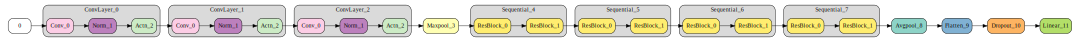

In [30]:
draw(explode(model))

Better! 

The next problem is a deeper one. When we try to ```explode``` the process stops at nodes which are not ```nn.Sequential``` (since these are the only type of node we know how to convert into graphs.)

Let's define a module to represent a general graph:


In [0]:
class Network(nn.Module):
    def __init__(self, graph, cache_activations=False):
        super().__init__()
        self.cache_activations = cache_activations
        self.graph = {k: (Network(v) if isinstance(v, dict) else v,i) for (k, (v,i)) in iter_nodes(graph)}
        
        for path, (val, _) in iter_nodes(self.graph): 
            setattr(self, path.replace('/', '_'), val)
    
    def forward(self, *args):
        prev = args[0]
        outputs = dict(enumerate(args))
        for k, (node, inputs) in iter_nodes(self.graph):
            if k not in outputs: 
                prev = outputs[k] = node(*[outputs[x] for x in inputs])
        if self.cache_activations: self.cache = outputs
        return prev

@to_graph.register(Network)
def f(x): return x.graph

and a new combinator, the ```SplitMerge``` layer:

In [0]:
class Mul(nn.Module):
    def forward(self, x, y): return x * y

class Add(nn.Module):
    def forward(self, x, y): return x + y

class SplitMerge(Network):
    def __init__(self, branches, merge=Add, **post):
        if isinstance(branches, list):
            branches = {f'branch{i}': branch for i in enumerate(branches)}
        graph = union({'in': nn.Identity()}, {k: (v, ['in']) for k,v in branches.items()})
        graph[short_name(merge)] = (merge(), list(branches.keys()))
        if post: graph = union(graph, post)
        super().__init__(graph)

Now let's redefine ```SEModule``` and ```ResBlock``` as ```SplitMerge``` layers (below we just do a minimal conversion from the existing layers but it should be clear how to write these directly)

In [0]:
class SEModule(SplitMerge):
    def __init__(self, orig):
        layers = orig.layers
        branches = {'SE': nn.Sequential(*layers[:-1]), 'shortcut': {}}
        super().__init__(branches, merge=Mul)    

class ResBlock(SplitMerge):
    def __init__(self, *args, se_convertor=SEModule, **kwargs):
        orig = fastai2.layers.ResBlock(*args, **kwargs)
        seq = lambda xs: nn.Sequential(*[x for x in xs if x != fastai2.imports.noop])
        branches = {
            'main': seq([*orig.convs._modules.values(), se_convertor(orig.se), orig.sa]), 
            'shortcut': seq([orig.pool, orig.idconv])
        }
        super().__init__(branches, Actn=orig.act)

def SeparableBlock(expansion, ni, nf, reduction=16, stride=1, base_width=4, **kwargs):
    return ResBlock(expansion, ni, nf, stride=stride, reduction=reduction, nh2=nf*2, dw=True, **kwargs)

In [34]:
model = fastai2.vision.models.xresnet.XResNet(SeparableBlock, 1, [2,2,2,2], c_in=3, c_out=10, sa=True)
draw(model)

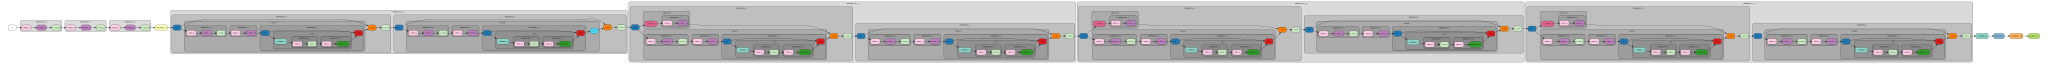

In [35]:
draw(explode(model), size=50)

It's fun to explore different levels of the hierarchy by apecifying the ```max_levels``` argument to ```explode```:

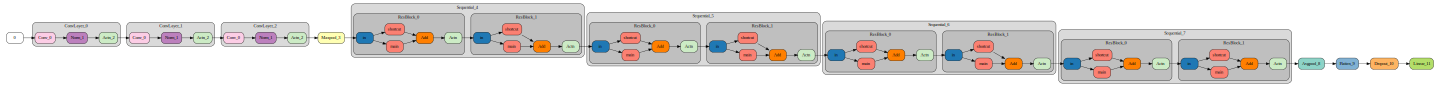

In [36]:
draw(explode(model,max_levels=2), size=20)

We can check that the fully exploded model (which is a perfectly good ```Network``` in itself) computes the same forward pass as the original model:


In [0]:
m = model.cuda()
m2 = Network(explode(m))
inputs = torch.randn(64,3,128,128).cuda()
assert torch.sum(torch.abs(m(inputs) - m2(inputs))).item() == 0.0

Note that if we set ```.cache_activations``` to true on the exploded model, we can retrieve all the intermediate activation values:

In [38]:
m2.cache_activations = True
m2(inputs)
list(m2.cache.keys())

[0,
 'ConvLayer_0/Conv_0',
 'ConvLayer_0/Norm_1',
 'ConvLayer_0/Actn_2',
 'ConvLayer_1/Conv_0',
 'ConvLayer_1/Norm_1',
 'ConvLayer_1/Actn_2',
 'ConvLayer_2/Conv_0',
 'ConvLayer_2/Norm_1',
 'ConvLayer_2/Actn_2',
 'Maxpool_3',
 'Sequential_4/ResBlock_0/in',
 'Sequential_4/ResBlock_0/main/ConvLayer_0/Conv_0',
 'Sequential_4/ResBlock_0/main/ConvLayer_0/Norm_1',
 'Sequential_4/ResBlock_0/main/ConvLayer_0/Actn_2',
 'Sequential_4/ResBlock_0/main/ConvLayer_1/Conv_0',
 'Sequential_4/ResBlock_0/main/ConvLayer_1/Norm_1',
 'Sequential_4/ResBlock_0/main/SEModule_2/in',
 'Sequential_4/ResBlock_0/main/SEModule_2/SE/Avgpool_0',
 'Sequential_4/ResBlock_0/main/SEModule_2/SE/ConvLayer_1/Conv_0',
 'Sequential_4/ResBlock_0/main/SEModule_2/SE/ConvLayer_1/Actn_1',
 'Sequential_4/ResBlock_0/main/SEModule_2/SE/ConvLayer_2/Conv_0',
 'Sequential_4/ResBlock_0/main/SEModule_2/SE/ConvLayer_2/Sigmoid_1',
 'Sequential_4/ResBlock_0/main/SEModule_2/Mul',
 'Sequential_4/ResBlock_0/Add',
 'Sequential_4/ResBlock_0/Actn',


In [39]:
m2.cache['Sequential_7/ResBlock_1/main/ConvLayer_1/Conv_0'][0][0]

tensor([[-0.4438, -1.8651,  1.0750,  0.6978],
        [-0.3466, -0.1547,  0.4273, -0.1287],
        [-0.4663,  2.3330,  0.1454,  1.2626],
        [ 1.1693,  1.5292, -0.0337,  0.9159]], device='cuda:0',
       grad_fn=<SelectBackward>)